## Notebook for Generation of Figures for Benchmark Study in Section 4.2

Import packages

In [1]:
import json
import logging
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

pd.options.mode.chained_assignment = None

Initiate variables

In [2]:
x_plot = np.arange(0, 1, 0.001)
x_plot50 = np.arange(0, 50, 0.01)

# Evaluation measures
sr_eval = ["crps", "me", "lgt", "cov"]

# Skill scores
sr_skill = ["crps"]

# Names of aggregation methods
agg_names = {
    "lp": "Linear Pool",
    "vi": "Vincentization",
    "vi-a": "Vincentization (a)",
    "vi-w": "Vincentization (w)",
    "vi-aw": "Vincentization (a, w)",
}
agg_abr = {
    "lp": r"LP",
    "vi": r"$V_0^=$",
    "vi-a": r"$V_a^=$",
    "vi-w": r"$V_0^w$",
    "vi-aw": r"$V_a^w$",
}

# Aggregation methods
agg_meths = list(agg_names.keys())

# Methods with coefficient estimation
coeff_meths = ["vi-a", "vi-w", "vi-aw"]

# Get colors
cols = sns.color_palette("Dark2", 8, as_cmap=True)

# Colors of aggregation methods
agg_col = {
    "lp": cols.colors[5],  # type: ignore
    "vi": cols.colors[4],  # type: ignore
    "vi-a": cols.colors[0],  # type: ignore
    "vi-w": cols.colors[2],  # type: ignore
    "vi-aw": cols.colors[3],  # type: ignore
    "ens": cols.colors[7],  # type: ignore
    "opt": cols.colors[6],  # type: ignore
}

# Colors with full names
agg_col_names = {agg_names[key]: value for key, value in agg_col.items() if key in agg_names}

# Line types of aggregation methods
agg_lty = {
    "lp": "dashed",
    "vi": "solid",
    "vi-a": "solid",
    "vi-w": "solid",
    "vi-aw": "solid",
    "ens": "dashdot",
    "opt": "dashdot",
}

# Names of datasets
set_names = {
    "gusts": "Wind",
    "protein": "Protein",
    "naval": "Naval",
    "power": "Power",
    "kin8nm": "Kin8nm",
    "scen_1": "Scenario 1",
    "scen_4": "Scenario 2",
    "wine": "Wine",
    "concrete": "Concrete",
    "energy": "Energy",
    "boston": "Boston",
    "yacht": "Yacht",
}

# Names of ensemble methods
ens_names = {
    "rand_init": "Random Initialization",
    "bagging": "Bagging",
    "batchensemble": "BatchEnsemble",
    "mc_dropout": "MC Dropout",
    "variational_dropout": "Variational Dropout",
    "concrete_dropout": "Concrete Dropout",
    "bayesian": "Bayesian",
}

# Abbrevaitions of ensemble methods
ens_abbr = {
    "rand_init": "Naive Ens.\\",
    "bagging": "Bagging",
    "batchensemble": "BatchEns.\\",
    "mc_dropout": "MC Dropout",
    "variational_dropout": "Var.\\ Dropout",
    "concrete_dropout": "Conc.\\ Dropout",
    "bayesian": "Bayesian",
}

Function for configuration data

In [3]:
# Set GIT-path
git_path = "path_to_repo"
git_path = "C:/Users/schulz/Documents/GitHub/ADDE/"

# Configuration function
def _get_config_info():
    ### Get Config ###
    with open(f"{git_path}/src/config_eval.json", "rb") as f:
        CONFIG = json.load(f)
    
    # Ensemble method
    ens_method = CONFIG["ENS_METHOD"]

    # Get available ensemble methods
    ens_method_ls = CONFIG["_available_ENS_METHOD"]
    
    # Path for figures
    plot_path = os.path.join(
        CONFIG["PATHS"]["GIT_DIR"],
        CONFIG["PATHS"]["PLOTS_DIR"],
        "benchmark_data",
    )

    # Path of data
    data_path = os.path.join(
        CONFIG["PATHS"]["DATA_DIR"],
        CONFIG["PATHS"]["RESULTS_DIR"],
        "dataset",
        ens_method,
    )

    # Path of network ensemble data
    data_ens_path = os.path.join(
        CONFIG["PATHS"]["DATA_DIR"],
        CONFIG["PATHS"]["RESULTS_DIR"],
        "dataset",
        ens_method,
        CONFIG["PATHS"]["ENSEMBLE_F"],
    )

    # Path of aggregated network data
    data_agg_path = os.path.join(
        CONFIG["PATHS"]["DATA_DIR"],
        CONFIG["PATHS"]["RESULTS_DIR"],
        "dataset",
        ens_method,
        CONFIG["PATHS"]["AGG_F"],
    )

    # Models considered
    dataset_ls = CONFIG["DATASET"]

    # Number of simulations
    n_sim = CONFIG["PARAMS"]["N_SIM"]

    # Ensemble size
    n_ens = CONFIG["PARAMS"]["N_ENS"]
    # Vector of ensemble members
    step_size = 2
    n_ens_vec = np.arange(
        start=step_size, stop=n_ens + step_size, step=step_size
    )

    # Network variants
    nn_vec = CONFIG["PARAMS"]["NN_VEC"]

    return (
        ens_method,
        ens_method_ls,
        plot_path,
        data_path,
        data_ens_path,
        data_agg_path,
        dataset_ls,
        n_sim,
        n_ens,
        n_ens_vec,
        nn_vec,
    )

Get configuration data

In [4]:
(
        ens_method,
        ens_method_ls,
        plot_path,
        data_path,
        data_ens_path,
        data_agg_path,
        dataset_ls,
        n_sim,
        n_ens,
        n_ens_vec,
        nn_vec,
    ) = _get_config_info()

Load evaluation data for generation of figures

In [5]:
with open(f"{git_path}/src/paper_figures_data.pkl", "rb") as f:
    df_plot = pickle.load(f)

### CRPS Ranking: LP vs. VI (no parameter estimation)

Prepare data

In [6]:
# Subset of only LP and VI
df_sub = df_plot[df_plot["agg"].isin(["lp", "vi"])]

# Create indices for pivoting
piv_cols = ['dataset', 'ens_method', 'nn', 'n_ens', 'n_sim']

# Pivoting
df_sub = df_sub.pivot(index=piv_cols, columns='agg', values='crps_rank')

# Create new colum
df_sub['best'] = df_sub.apply(lambda row: 'lp' if row['lp'] < row['vi'] else 'vi', axis=1)

# Reset index to convert pivot table back to DataFrame
df_sub.reset_index(inplace=True)

# Melt the DataFrame back to long format
df_sub = df_sub.melt(id_vars=piv_cols + ['best'], value_vars=['lp', 'vi'], var_name='agg', value_name='crps_rank')

# Sort the DataFrame to match original order
df_sub = df_sub.sort_values(by=piv_cols + ['agg']).reset_index(drop=True)

# Cut to only one
df_sub = df_sub[df_sub['agg'] == "lp"]
df_sub = df_sub.drop(columns="agg")

Generate figure

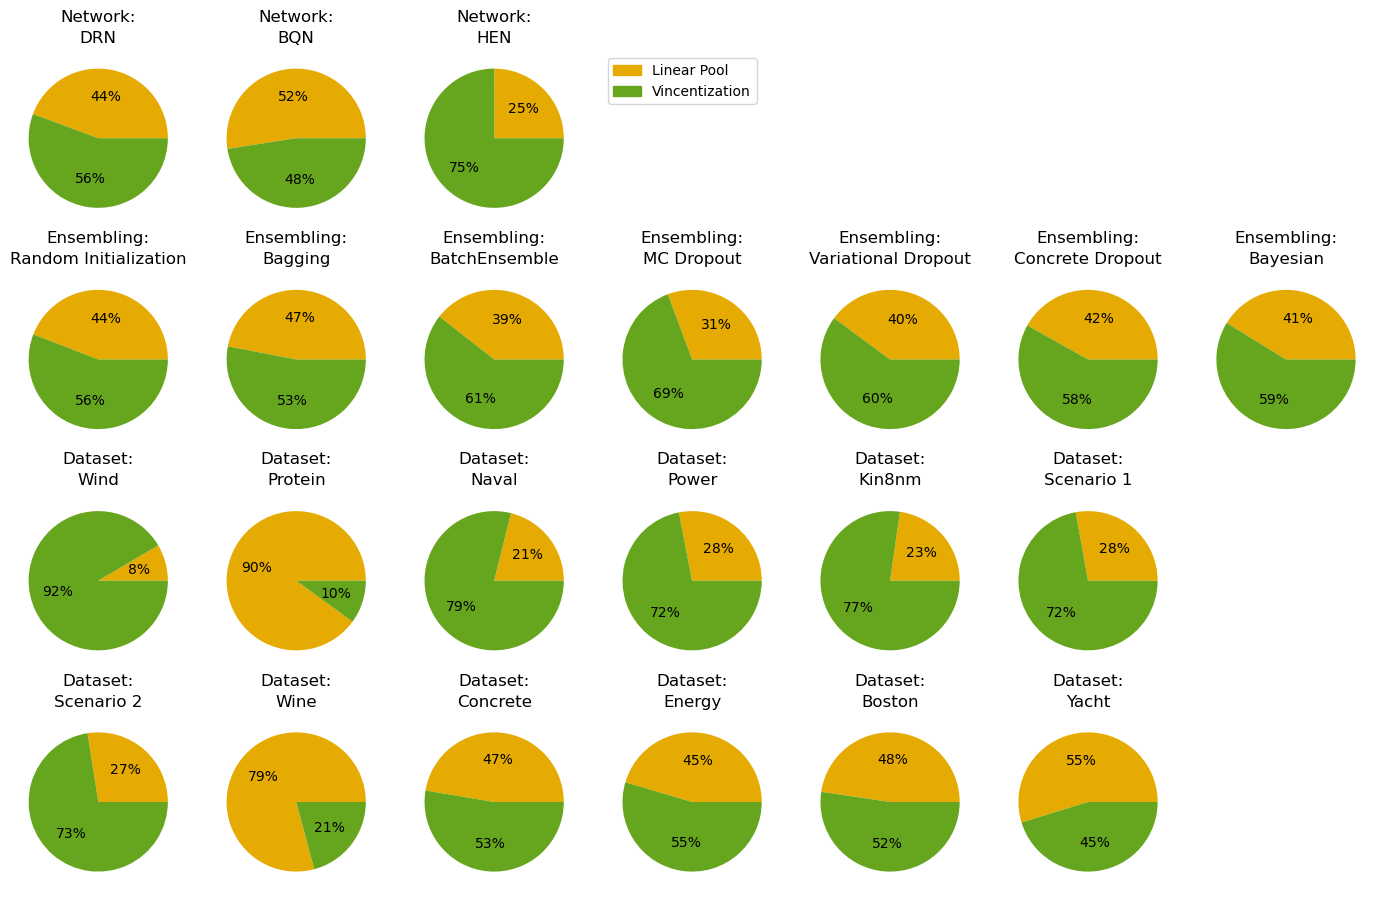

In [9]:
# Shape of panel
n_col = 7
n_row = 4

# Create subplots
fig, axes = plt.subplots(
    nrows=n_row, 
    ncols=n_col, 
    figsize=(14, 9),
)

# Start counter
i_axes = 0
i_row = 0
i_col = 0

# For-Loop over columns of interest
for temp_col in ['nn', 'ens_method', 'dataset']:
    # Group by 'col' and 'agg' and count the occurrences
    grouped = df_sub.groupby([temp_col, 'best']).size().reset_index(name='counts')

    # Set 'col' values
    if temp_col == 'nn': 
        col_values = [x.upper() for x in nn_vec]
    elif temp_col == 'ens_method': 
        col_values = ens_method_ls
    elif temp_col == 'dataset': 
        col_values = set_names.values()
    
    # Plot pie charts
    for i, col_value in enumerate(col_values):
        # Subset the grouped DataFrame for the current col value
        col_group = grouped[grouped[temp_col] == col_value]
        col_colors = [agg_col[temp_agg] for temp_agg in col_group["best"]]
    
        # Add legend
        if (n_col - (i_axes + 1) <= 3) and (i_row == 0) or ((i_axes + 1) % n_col == 0) and (i_row in [2, 3]): 
            # Get indices
            i_row = i_axes // n_col
            i_col = i_axes % n_col 

            # Empty plot
            axes[i_row, i_col].axis('off')

            # Only first row
            if i_row == 0:
                # Create handles as placeholders
                legend_handles = [
                    mpatches.Patch(color=agg_col[key], label=agg_names[key]) 
                    for key in ['lp', 'vi'] 
                ]

                # Empty plot
                axes[i_row, i_col].legend(
                    handles=legend_handles,
                    loc='upper left',
                )

                # Increase figure counter
                i_axes += 1

                # Three empty plots for first row
                for temp in range(3):
                    # Get indices
                    i_row = i_axes // n_col
                    i_col = i_axes % n_col 

                    # Empty plot
                    axes[i_row, i_col].axis('off')

                    # Increase figure counter
                    i_axes += 1
            else:
                # Increase figure counter
                i_axes += 1
        
        # Get indices
        i_row = i_axes // n_col
        i_col = i_axes % n_col

        # Generate labels
        labels = [x.upper() for x in col_group['best']]

        # Plot pie chart
        axes[i_row, i_col].pie(
            col_group['counts'], 
            pctdistance=0.6, 
            colors=col_colors, 
            autopct='%1.0f%%',
        )

        # Get title
        if temp_col == 'nn': 
            title = f'Network:\n{col_value}'
        elif temp_col == 'ens_method': 
            title = f'Ensembling:\n{ens_names[col_value]}'
        elif temp_col == 'dataset': 
            title = f'Dataset:\n{col_value}'
        
        # Set title
        axes[i_row, i_col].set_title(title, linespacing=1.5)

        # Increase figure counter
        i_axes += 1

# Get indices
i_row = i_axes // n_col
i_col = i_axes % n_col 

# Empty plot
axes[i_row, i_col].axis('off')

# Adjust horizontal/vertical spaces in subplot
plt.subplots_adjust(
    wspace=0.0,
    hspace=0.0,
)

# Adjust layout
plt.tight_layout()
plt.show()

# Save fig
filename = os.path.join(plot_path, f"vi_lp_pie.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

### CRPS Ranking: All variants

Prepare data (Data preparation from previous CRPS ranking required)

In [10]:
# Filter for crps_rank == 1
df_sub = df_plot[df_plot['crps_rank'] == 1]

Generate figure

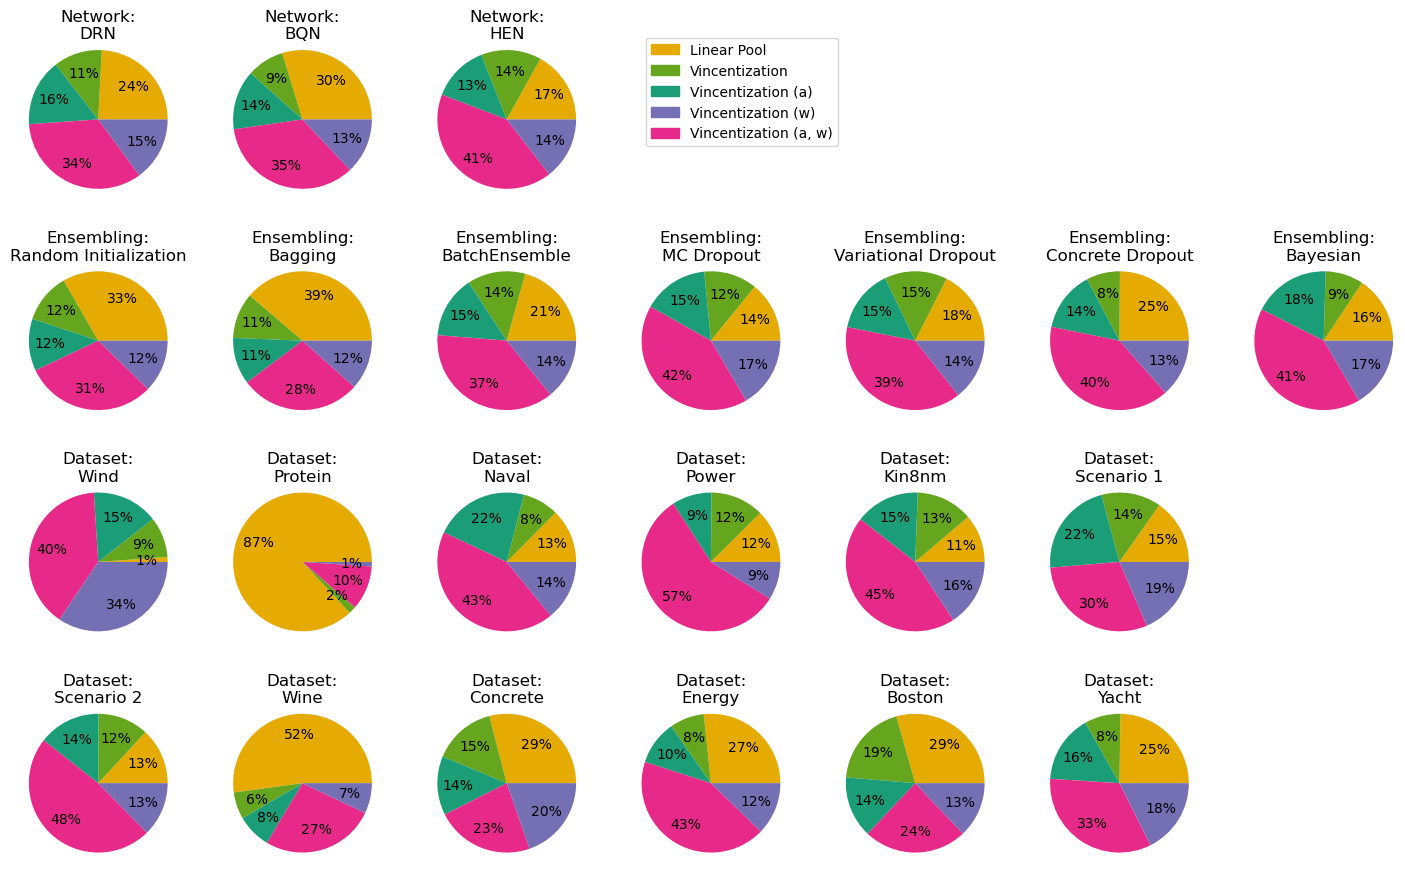

In [11]:
# Shape of panel
n_col = 7
n_row = 4

# Create subplots
fig, axes = plt.subplots(
    nrows=n_row, 
    ncols=n_col, 
    figsize=(14, 9),
)

# Start counter
i_axes = 0
i_row = 0
i_col = 0

# For-Loop over columns of interest
for temp_col in ['nn', 'ens_method', 'dataset']:
    # Group by 'col' and 'agg' and count the occurrences
    grouped = df_sub.groupby([temp_col, 'agg']).size().reset_index(name='counts')

    # Set 'col' values
    if temp_col == 'nn': 
        col_values = [x.upper() for x in nn_vec]
    elif temp_col == 'ens_method': 
        col_values = ens_method_ls
    elif temp_col == 'dataset': 
        col_values = set_names.values()
    
    # Plot pie charts
    for i, col_value in enumerate(col_values):
        # Subset the grouped DataFrame for the current col value
        col_group = grouped[grouped[temp_col] == col_value]
        
        # Throw out vi-a for Protein (visual reasons due to 0%)
        if col_value == "Protein":
            col_group = col_group[col_group['agg'] != 'vi-a']

        # Get colors
        col_colors = [agg_col[temp_agg] for temp_agg in col_group["agg"]]
    
        # Add legend
        if (n_col - (i_axes + 1) <= 3) and (i_row == 0) or ((i_axes + 1) % n_col == 0) and (i_row in [2, 3]): 
            # Get indices
            i_row = i_axes // n_col
            i_col = i_axes % n_col 

            # Empty plot
            axes[i_row, i_col].axis('off')

            # Only first row
            if i_row == 0:
                # Create handles as placeholders
                legend_handles = [mpatches.Patch(color=agg_col[key], label=agg_names[key]) for key, value in agg_col.items() if key in agg_names ]

                # Empty plot
                axes[i_row, i_col].legend(
                    handles=legend_handles,
                    loc='upper left',
                )

                # Increase figure counter
                i_axes += 1

                # Three empty plots for first row
                for temp in range(3):
                    # Get indices
                    i_row = i_axes // n_col
                    i_col = i_axes % n_col 

                    # Empty plot
                    axes[i_row, i_col].axis('off')

                    # Increase figure counter
                    i_axes += 1
            else:
                # Increase figure counter
                i_axes += 1
        
        # Get indices
        i_row = i_axes // n_col
        i_col = i_axes % n_col

        # Generate labels
        labels = [x.upper() for x in col_group['agg']]

        # Plot pie chart
        axes[i_row, i_col].pie(
            col_group['counts'], 
            pctdistance=0.7,
            autopct='%1.0f%%',
            radius = 1.2,
            colors=col_colors
        )

        # Get title
        if temp_col == 'nn': 
            title = f'Network:\n{col_value}'
        elif temp_col == 'ens_method': 
            title = f'Ensembling:\n{ens_names[col_value]}'
        elif temp_col == 'dataset': 
            title = f'Dataset:\n{col_value}'
        
        # Set title
        axes[i_row, i_col].set_title(title)

        # Increase figure counter
        i_axes += 1

# Get indices
i_row = i_axes // n_col
i_col = i_axes % n_col 

# Empty plot
axes[i_row, i_col].axis('off')

# Adjust horizontal/vertical spaces in subplot
plt.subplots_adjust(
    wspace=0.0,
    hspace=0.0,
)

# Adjust layout
plt.tight_layout()
plt.show()

# Save fig
filename = os.path.join(plot_path, f"pie.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

### Distribution CRPS Ranking

Generate figure for network variants

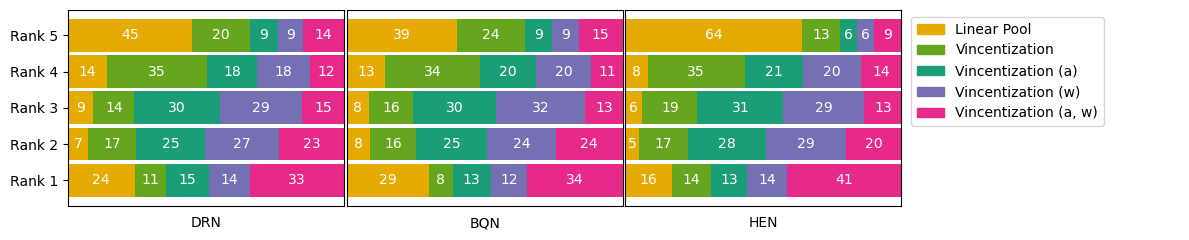

In [10]:
# Shape of panel
n_col = 4
n_row = 1

# Define plot structure
fig, axes = plt.subplots(n_row, n_col, figsize=(12, 2.5))

# For-Loop over networkv ariants
for i_axes, temp_nn in enumerate(nn_vec):
    # Function to count number of each rank
    def get_counts(i):
        return [len(df_plot[(df_plot["nn"] == temp_nn.upper()) & 
                        (df_plot["agg"] == x) & 
                        (df_plot["crps_rank"] == i)]) for x in agg_meths]

    # For each network variant
    # Create dict with counts for each rank in order of agg_mehts
    df_counts = {}
    for i in reversed(range(1, 6)):
        df_counts[f"Rank {i}"] = get_counts(i)

    # Get rank labels
    labels = list(df_counts.keys())
    
    # Transform to numpy array
    data = np.array(list(df_counts.values()))

    # Relative frequencies
    data = data/data.sum(axis=1)[:,np.newaxis]

    # Cumulative frequencies for barplots
    data_cum = data.cumsum(axis=1)

    # Invert y-axis for horizontal barplots
    axes[i_axes,].invert_yaxis()
    
    # Limits of x-axis
    axes[i_axes,].set_xlim(0, np.sum(data, axis=1).max())

    # No x-ticks
    axes[i_axes,].set_xticks([])
    
    # Label x-axis with network variant
    axes[i_axes,].set_xlabel(temp_nn.upper())

    # Only y-axis label on left side
    if i_axes != 0: 
        axes[i_axes,].yaxis.set_visible(False)

    # Plot bar plots for each aggregation method    
    for i, colname in enumerate(agg_meths):
        # Get width of bars
        widths = data[:, i]

        # Get starting point of bars (dependent on previous bars)
        starts = data_cum[:, i] - widths

        # Plot bars
        axes[i_axes,].barh(labels, 
                widths, 
                left=starts, 
                height=0.9, 
                color=agg_col[colname],
                label=agg_names[colname])
        
        # Get center of bars for texts
        xcenters = starts + widths / 2

        # Plot percentages as text
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            # Only if rounded percentage value is larger than 4
            if int(100*c) > 4:
                axes[i_axes,].text(x, y, 
                    # f'{c:.0%}', 
                    str(int(100*c)), 
                    ha='center', 
                    va='center',
                    color='white')
    
# Empty plot
axes[3,].axis('off')

# Create handles as placeholders
legend_handles = [mpatches.Patch(color=agg_col[key], label=agg_names[key]) for key, value in agg_col.items() if key in agg_names ]

# Add legend
axes[3,].legend(handles=legend_handles,
                loc='upper left')

# Optimize layout automatically
plt.tight_layout()

# Adjust horizontal/vertical spaces in subplot
plt.subplots_adjust(wspace=0.01)

# Show plot
plt.show()

# Save fig
filename = os.path.join(plot_path, f"rank_barplots_nn.pdf")
fig.savefig(filename)
plt.close(fig)

Generate figure for ensembling strategies

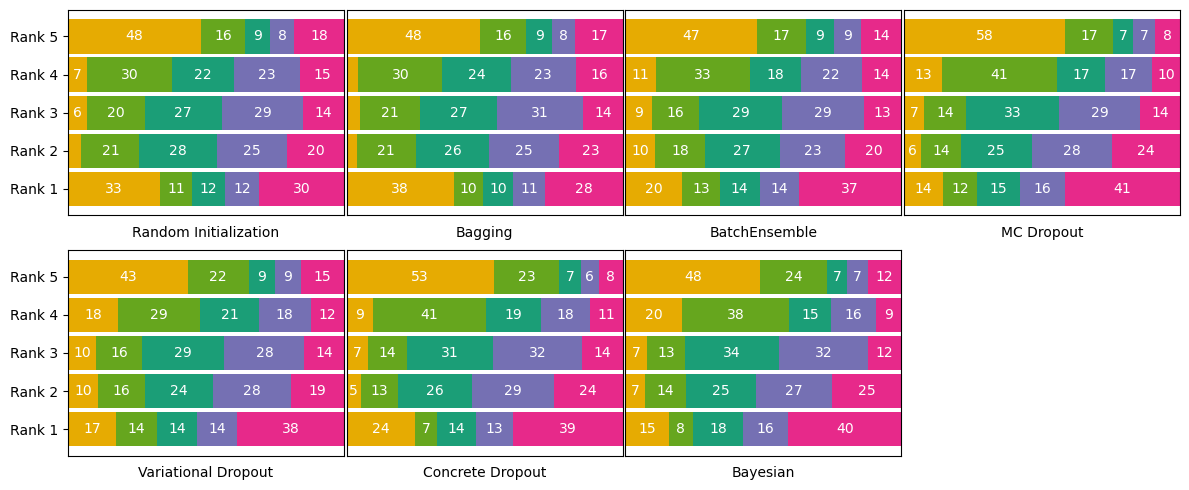

In [12]:
# Shape of panel
n_col = 4
n_row = 2

# Define plot structure
fig, axes = plt.subplots(n_row, n_col, figsize=(12, 5))

# For-Loop over networkv ariants
for i_axes, temp_ens in enumerate(ens_method_ls):
    # Get indices of axes
    i_row = i_axes // n_col
    i_col = i_axes % n_col
    
    # Function to count number of each rank
    def get_counts(i):
        return [len(df_plot[(df_plot["ens_method"] == temp_ens) & 
                        (df_plot["agg"] == x) & 
                        (df_plot["crps_rank"] == i)]) for x in agg_meths]

    # For each network variant
    # Create dict with counts for each rank in order of agg_mehts
    df_counts = {}
    for i in reversed(range(1, 6)):
        df_counts[f"Rank {i}"] = get_counts(i)

    # Get rank labels
    labels = list(df_counts.keys())
    
    # Transform to numpy array
    data = np.array(list(df_counts.values()))

    # Relative frequencies
    data = data/data.sum(axis=1)[:,np.newaxis]

    # Cumulative frequencies for barplots
    data_cum = data.cumsum(axis=1)

    # Invert y-axis for horizontal barplots
    axes[i_row, i_col].invert_yaxis()
    
    # Limits of x-axis
    axes[i_row, i_col].set_xlim(0, np.sum(data, axis=1).max())

    # No x-ticks
    axes[i_row, i_col].set_xticks([])
    
    # Label x-axis with network variant
    axes[i_row, i_col].set_xlabel(ens_names[temp_ens])

    # Only y-axis label on left side
    if i_col != 0: 
        axes[i_row, i_col].yaxis.set_visible(False)

    # Plot bar plots for each aggregation method    
    for i, colname in enumerate(agg_meths):
        # Get width of bars
        widths = data[:, i]

        # Get starting point of bars (dependent on previous bars)
        starts = data_cum[:, i] - widths

        # Plot bars
        axes[i_row, i_col].barh(labels, 
                widths, 
                left=starts, 
                height=0.9, 
                color=agg_col[colname],
                label=agg_names[colname])
        
        # Get center of bars for texts
        xcenters = starts + widths / 2

        # Plot percentages as text
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            # Only if rounded percentage value is larger than 4
            if int(100*c) > 4:
                axes[i_row, i_col].text(x, y, 
                    str(int(100*c)), 
                    ha='center', 
                    va='center',
                    color='white')

# Empty plot
axes[1, 3].axis('off')

# Optimize layout automatically
plt.tight_layout()

# Adjust horizontal/vertical spaces in subplot
plt.subplots_adjust(wspace=0.01)
plt.subplots_adjust(hspace=0.17)

# Show plot
plt.show()

# Save fig
filename = os.path.join(plot_path, f"rank_barplots_ens.pdf")
fig.savefig(filename)
plt.close(fig)

Generate figure for data sets

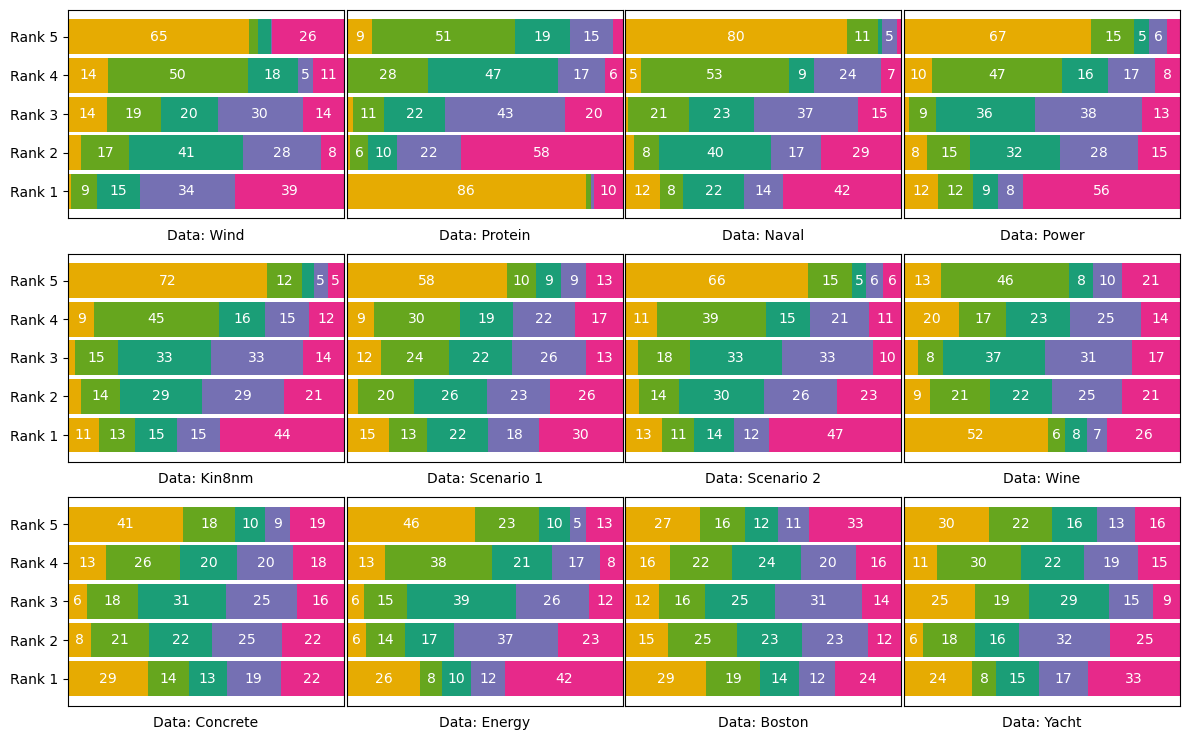

In [12]:
# Shape of panel
n_col = 4
n_row = 3

# Define plot structure
fig, axes = plt.subplots(n_row, n_col, figsize=(12, 7.5))

# For-Loop over networkv ariants
for i_axes, temp_set in enumerate(set_names.values()):
    # Get indices of axes
    i_row = i_axes // n_col
    i_col = i_axes % n_col
    
    # Function to count number of each rank
    def get_counts(i):
        return [len(df_plot[(df_plot["dataset"] == temp_set) & 
                        (df_plot["agg"] == x) & 
                        (df_plot["crps_rank"] == i)]) for x in agg_meths]

    # For each network variant
    # Create dict with counts for each rank in order of agg_mehts
    df_counts = {}
    for i in reversed(range(1, 6)):
        df_counts[f"Rank {i}"] = get_counts(i)

    # Get rank labels
    labels = list(df_counts.keys())
    
    # Transform to numpy array
    data = np.array(list(df_counts.values()))

    # Relative frequencies
    data = data/data.sum(axis=1)[:,np.newaxis]

    # Cumulative frequencies for barplots
    data_cum = data.cumsum(axis=1)

    # Invert y-axis for horizontal barplots
    axes[i_row, i_col].invert_yaxis()
    
    # Limits of x-axis
    axes[i_row, i_col].set_xlim(0, np.sum(data, axis=1).max())

    # No x-ticks
    axes[i_row, i_col].set_xticks([])
    
    # Label x-axis with network variant
    axes[i_row, i_col].set_xlabel(f"Data: {temp_set}")

    # Only y-axis label on left side
    if i_col != 0: 
        axes[i_row, i_col].yaxis.set_visible(False)

    # Plot bar plots for each aggregation method    
    for i, colname in enumerate(agg_meths):
        # Get width of bars
        widths = data[:, i]

        # Get starting point of bars (dependent on previous bars)
        starts = data_cum[:, i] - widths

        # Plot bars
        axes[i_row, i_col].barh(labels, 
                widths, 
                left=starts, 
                height=0.9, 
                color=agg_col[colname],
                label=agg_names[colname])
        
        # Get center of bars for texts
        xcenters = starts + widths / 2

        # Plot percentages as text
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            # Only if rounded percentage value is larger than 4
            if int(100*c) > 4:
                axes[i_row, i_col].text(x, y, 
                        str(int(100*c)), 
                        ha='center', 
                        va='center',
                        color='white')

# Optimize layout automatically
plt.tight_layout()

# Adjust horizontal/vertical spaces in subplot
plt.subplots_adjust(wspace=0.01)
plt.subplots_adjust(hspace=0.17)

# Show plot
plt.show()

# Save fig
filename = os.path.join(plot_path, f"rank_barplots_datasets.pdf")
fig.savefig(filename)
plt.close(fig)

### Boxplots of Relative PI Length Differences

Generate figure for network variants

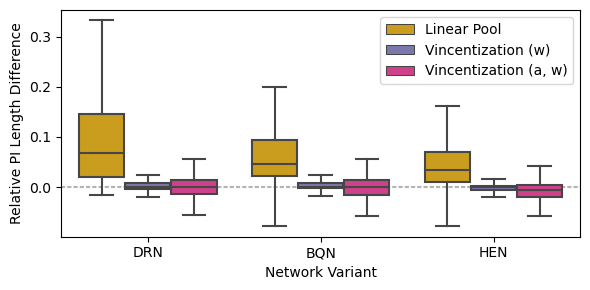

In [13]:
# Define figure size
plt.rcParams['figure.figsize'] = [6, 3]

# Generate boxplots
g = sns.boxplot(
    data=df_plot[df_plot["agg"].isin(["lp", "vi-w", "vi-aw"])],
    x = "nn", 
    y = "lgt_reldif", 
    hue="agg", 
    palette=agg_col,
    showfliers = False,
)

# Benchmark line for no differences
g.axhline(y=0, color=".7", dashes=(2, 1), zorder=0)

# Axis labels
plt.xlabel('Network Variant')
plt.ylabel('Relative PI Length Difference')

# Legend
handles, _ = g.get_legend_handles_labels()
labels = [agg_names[key] for key in ["lp", "vi-w", "vi-aw"]]
plt.legend(handles, labels,
           loc='upper right', 
           )

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.get_figure()
filename = os.path.join(plot_path, f"lgt_boxplot_nn.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

Generate figure for ensembling strategies

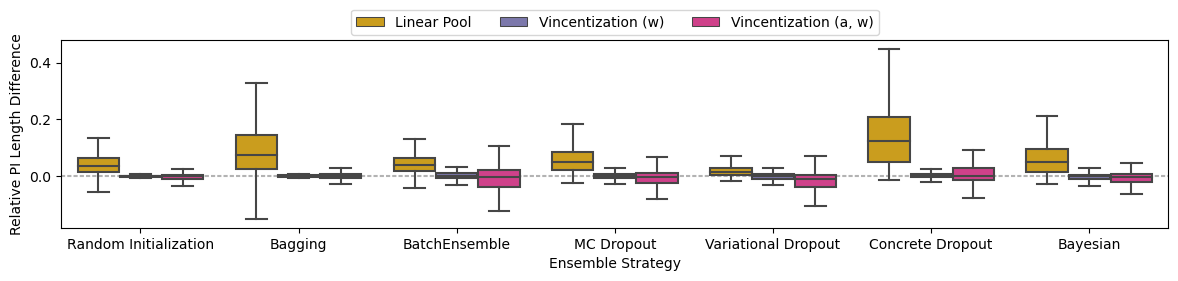

In [14]:
# Define figure size
plt.rcParams['figure.figsize'] = [12, 3]

# Generate boxplots
g = sns.boxplot(
    data=df_plot[df_plot["agg"].isin(["lp", "vi-w", "vi-aw"])],
    x = "ens_method", 
    y = "lgt_reldif", 
    hue="agg", 
    palette=agg_col,
    showfliers = False,
)

# Benchmark line for no differences
g.axhline(y=0, color=".7", dashes=(2, 1), zorder=0)

# Axis labels
plt.xlabel('Ensemble Strategy')
plt.ylabel('Relative PI Length Difference')

# Set names of ticks
g.set_xticklabels(ens_names.values())

# Legend
handles, _ = g.get_legend_handles_labels()
labels = [agg_names[key] for key in ["lp", "vi-w", "vi-aw"]]
plt.legend(handles, labels,
           loc='upper center', 
           ncol=len(agg_names),
           bbox_to_anchor=(0.5, 1.2), 
           )

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.get_figure()
filename = os.path.join(plot_path, f"lgt_boxplot_ens.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

Generate figure for data sets

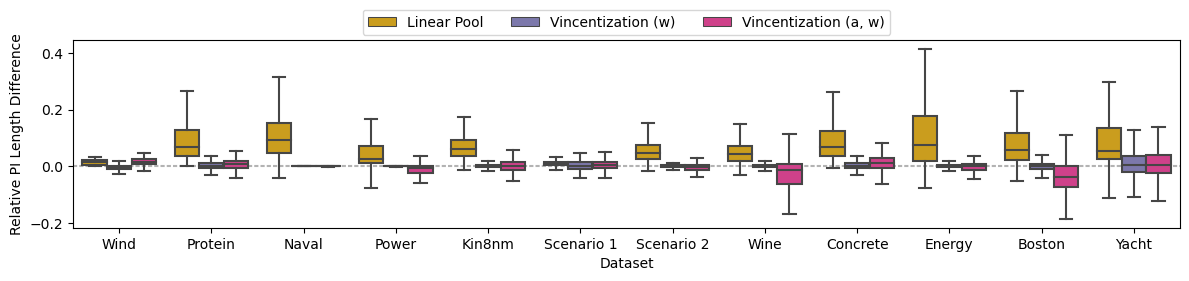

In [15]:
# Define figure size
plt.rcParams['figure.figsize'] = [12, 3]

# Generate boxplots
g = sns.boxplot(
    data=df_plot[df_plot["agg"].isin(["lp", "vi-w", "vi-aw"])],
    x = "dataset", 
    y = "lgt_reldif", 
    hue="agg", 
    palette=agg_col,
    showfliers = False,
    order=set_names.values(),
)

# Benchmark line for no differences
g.axhline(y=0, color=".7", dashes=(2, 1), zorder=0)

# Axis labels
plt.xlabel('Dataset')
plt.ylabel('Relative PI Length Difference')

# Legend
handles, _ = g.get_legend_handles_labels()
labels = [agg_names[key] for key in ["lp", "vi-w", "vi-aw"]]
plt.legend(handles, labels,
           loc='upper center', 
           ncol=len(agg_names),
           bbox_to_anchor=(0.5, 1.2), 
           )

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.get_figure()
filename = os.path.join(plot_path, f"lgt_boxplot_datasets.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

### Boxplots of PI Coverages

Calculate differences

In [16]:
df_plot["cov_dif"] = df_plot["cov"] - df_plot["cov_ref"]

Generate figure for network variants

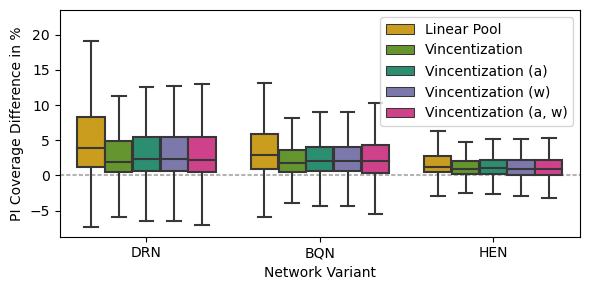

In [17]:
# Define figure size
plt.rcParams['figure.figsize'] = [6, 3]

# Generate boxplots
g = sns.boxplot(
    data=df_plot,
    x = "nn", 
    y = "cov_dif", 
    hue="agg", 
    palette=agg_col,
    showfliers = False,
)

# Set y-limit
g.set_ylim(top=23.5)

# Benchmark line for no differences
g.axhline(y=0, color=".7", dashes=(2, 1), zorder=0)

# Axis labels
plt.xlabel('Network Variant')
plt.ylabel('PI Coverage Difference in %')

# Legend
handles, _ = g.get_legend_handles_labels()
plt.legend(handles, agg_names.values(),
           loc='upper right', 
           )

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.get_figure()
filename = os.path.join(plot_path, f"cov_diff_boxplot_nn.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

Generate figure for ensembling strategies

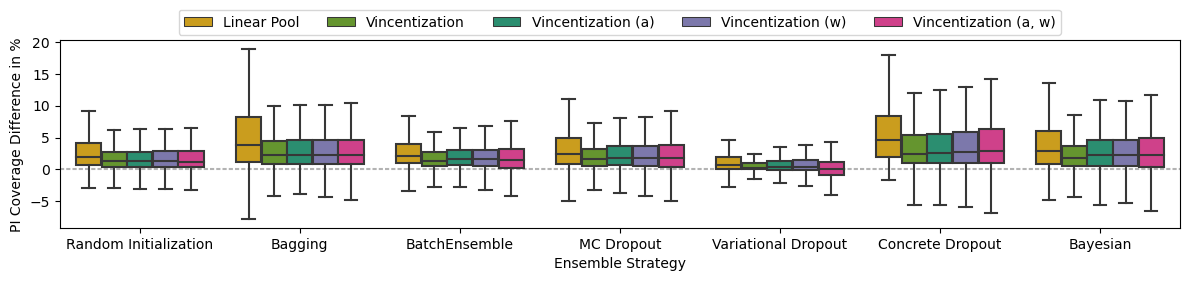

In [18]:
# Define figure size
plt.rcParams['figure.figsize'] = [12, 3]

# Generate boxplots
g = sns.boxplot(
    data=df_plot,
    x = "ens_method", 
    y = "cov_dif", 
    hue="agg", 
    palette=agg_col,
    showfliers = False,
)

# Benchmark line for no differences
g.axhline(y=0, color=".7", dashes=(2, 1), zorder=0)

# Axis labels
plt.xlabel('Ensemble Strategy')
plt.ylabel('PI Coverage Difference in %')

# Set names of ticks
g.set_xticklabels(ens_names.values())

# Legend
handles, _ = g.get_legend_handles_labels()
plt.legend(handles, agg_names.values(),
           loc='upper center', 
           ncol=len(agg_names),
           bbox_to_anchor=(0.5, 1.2), 
           )

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.get_figure()
filename = os.path.join(plot_path, f"cov_diff_boxplot_ens.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

Generate figure for data sets

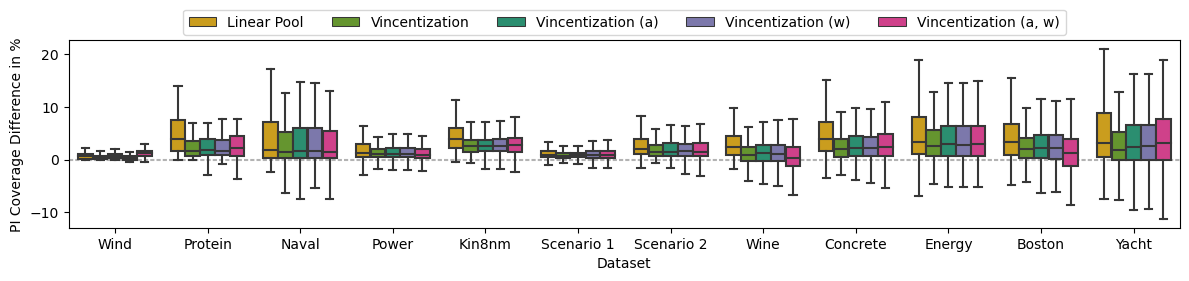

In [19]:
# Define figure size
plt.rcParams['figure.figsize'] = [12, 3]

# Generate boxplots
g = sns.boxplot(
    data=df_plot,
    x = "dataset", 
    y = "cov_dif", 
    hue="agg", 
    order=set_names.values(),
    palette=agg_col,
    showfliers = False,
)

# Benchmark line for no differences
g.axhline(y=0, color=".7", dashes=(2, 1), zorder=0)

# Axis labels
plt.xlabel('Dataset')
plt.ylabel('PI Coverage Difference in %')

# Legend
handles, _ = g.get_legend_handles_labels()
plt.legend(handles, agg_names.values(),
           loc='upper center', 
           ncol=len(agg_names),
           bbox_to_anchor=(0.5, 1.2), 
           )

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.get_figure()
filename = os.path.join(plot_path, f"cov_diff_boxplot_datasets.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

### Regression Analysis for CRPS Ranking

Dependent on PI coverage of ensemble

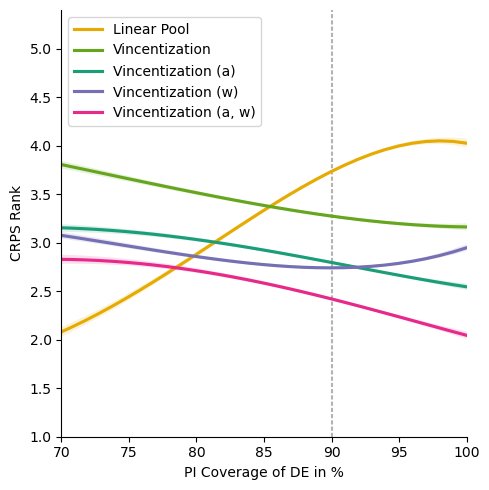

In [20]:
# Define figure size
plt.rcParams['figure.figsize'] = [5, 3]

# Define order of regression
lm_order = 4

# Perform regression analysis and plot
g = sns.lmplot(
    data=df_plot, 
    x="cov_ref", y="crps_rank", hue="agg",
    order=lm_order,
    palette=agg_col,
    scatter=False,
    legend=False,
)

# Set axis limits
g.set(xlim=(70,100))
g.set(ylim=(1,5.4))

# Set axis labels
g.set_xlabels('PI Coverage of DE in %')
g.set_ylabels('CRPS Rank')

# Benchmark line calibration
plt.axvline(x=90, color=".7", dashes=(2, 1), zorder=1)

# Legend
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(
    handles, agg_names.values(),
    loc="upper left",
)

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.figure
filename = os.path.join(plot_path, f"cov_rank_{lm_order}_analysis.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

Dependent on variance of PIT (dispersion)

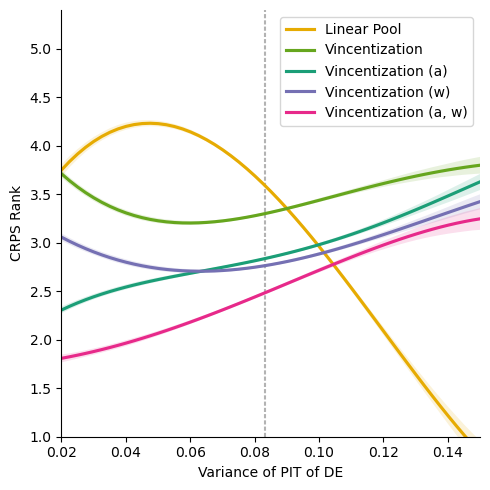

In [21]:
# Define figure size
plt.rcParams['figure.figsize'] = [5, 3]

# Define order of regression
lm_order = 4

# Perform regression analysis and plot
g = sns.lmplot(
    data=df_plot, 
    x="var_pit_ref", y="crps_rank", hue="agg",
    order=lm_order,
    palette=agg_col,
    scatter=False,
    legend=False,
)

# Set axis limits
g.set(xlim=(0.02,0.15))
g.set(ylim=(1,5.4))

# Set axis labels
g.set_xlabels('Variance of PIT of DE')
g.set_ylabels('CRPS Rank')

# Benchmark line calibration
plt.axvline(x=1/12, color=".7", dashes=(2, 1), zorder=1)

# Legend
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(
    handles, agg_names.values(),
    loc="upper right",
)

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.figure
filename = os.path.join(plot_path, f"disp_rank_{lm_order}_analysis.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

Dependent on PI coverage of ensemble diversity metrics

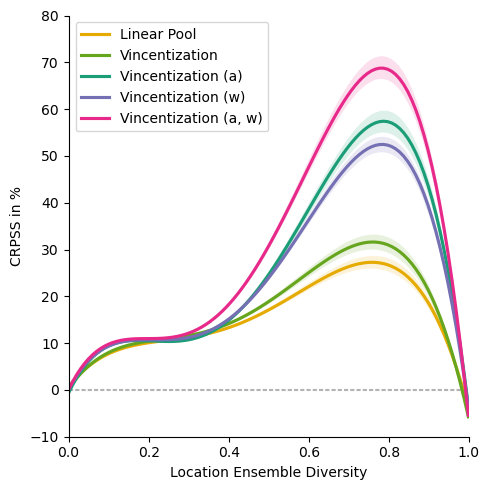

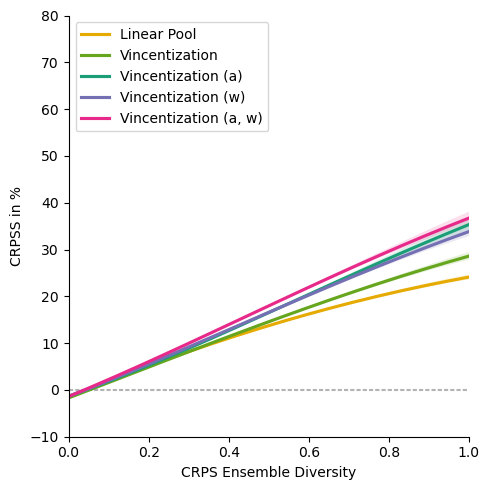

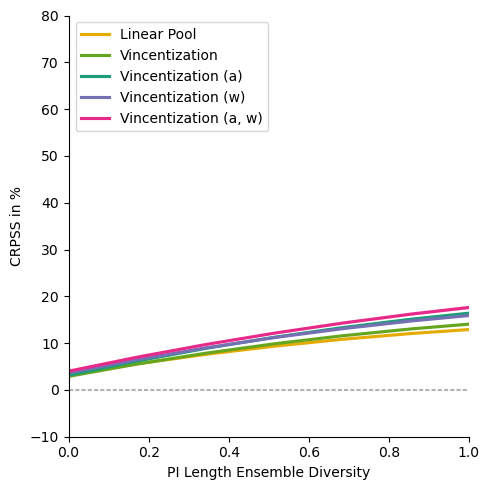

In [25]:
# Define figure size
plt.rcParams['figure.figsize'] = [5, 3]

# Define order of regression
lm_order = 4

# For-Loop over target ("crps_rank" also possible)
for temp_target in ["crpss"]:
    # For-Loop over diversity metrics
    for temp_div in ['div_loc_z', 'div_crps_z', 'div_lgt_z']:
        ### When using scatter, handles for legend need to be generated beforehand
        # # Perform regression analysis on subset
        # g = sns.lmplot(
        #     data=df_plot[df_plot["n_sim"] <= 1], 
        #     x=temp_div, y=temp_target, 
        #     hue="agg",
        #     order=lm_order,
        #     palette=agg_col,
        #     scatter=False,
        #     legend=False,  
        # )

        # # Generate handles for legend beforehand as it does not work with scatter
        # handles, _ = plt.gca().get_legend_handles_labels()

        # # Do not show dummy
        # fig = g.figure
        # plt.close(fig)

        # Perform regression analysis and plott (on full data)
        g = sns.lmplot(
            data=df_plot, 
            x=temp_div, y=temp_target, 
            hue="agg",
            order=lm_order,
            palette=agg_col,
            scatter=False,
            legend=False,  
        )

        # Set y-axis limits and labels depebdent on target
        if temp_target == "crps_rank":
            g.set(ylim=(1,5))
            g.set_ylabels('CRPS Rank')
        if temp_target == "crpss":
            g.set(ylim=(-10,80))
            g.set_ylabels('CRPSS in %')

        # Differentiate for diversity metric
        if temp_div == "div_loc_z":
            temp_name = 'Location'
        elif temp_div == "div_crps_z":
            temp_name = 'CRPS'
        elif temp_div == "div_lgt_z":
            temp_name = 'PI Length'
            
        # Set x-axis limit and label
        g.set(xlim=(0,1))
        g.set_xlabels(f'{temp_name} Ensemble Diversity')

        # Benchmark line no skill
        if temp_target == "crpss":
            plt.axhline(y=0, color=".7", dashes=(2, 1), zorder=1)

        # Legend
        handles, _ = plt.gca().get_legend_handles_labels()
        plt.legend(
            handles, agg_names.values(),
            loc="upper left",
        )
        
        # Optimize layout
        plt.tight_layout()
        plt.show()

        # Save fig
        fig = g.figure
        filename = os.path.join(plot_path, f"{temp_div}_{temp_target}_rank_{lm_order}_analysis.png")
        fig.savefig(filename)
        log_message = f"Panel saved to {filename}"
        logging.info(log_message)
        plt.close(fig)

### Boxplots of PI Length Differences dependent on Ensemble Size

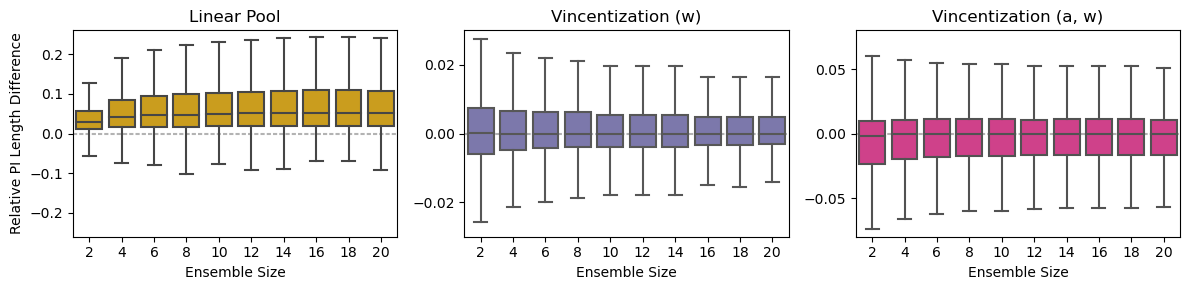

In [23]:
# Define figure size
plt.rcParams['figure.figsize'] = [12, 3]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Aggregation methods considered
temp_meths = ["lp", "vi-w", "vi-aw"]

# For-Loop over networks
for i, col_value in enumerate(temp_meths):
    # Subset 
    df_sub = df_plot[df_plot["agg"] == col_value]

    # Plot boxplots
    sns.boxplot(
        data=df_sub,
        x = "n_ens", 
        y = "lgt_reldif", 
        color=agg_col[col_value],
        showfliers = False,
        ax=axes[i],
    )

    # Benchmark line no difference
    axes[i].axhline(y=0, color=".7", dashes=(2, 1), zorder=0)

    # Set title
    axes[i].set_title(agg_names[col_value])
    
    # Set x-label
    axes[i].set_xlabel('Ensemble Size')
    
    # Set y-label
    if i== 0:
        axes[i].set_ylabel('Relative PI Length Difference')
    else:
        axes[i].set_ylabel(None)

    # Manually choose y-limit
    if col_value == "lp": temp_ylim = 0.26
    elif col_value == "vi-w": temp_ylim = 0.03
    elif col_value == "vi-aw": temp_ylim = 0.08

    # Set y-limits (symmetric)
    axes[i].set_ylim((-temp_ylim, temp_ylim))

    # Manually choose y-limit
    if col_value == "lp": 
        axes[i].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    elif col_value == "vi-w": 
        axes[i].set_yticks([-0.02, 0, 0.02])
    elif col_value == "vi-aw": 
        axes[i].set_yticks([-0.05, 0, 0.05])

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
filename = os.path.join(plot_path, f"n_ens_lgt_boxplot.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)

### CRPS Improvement dependent on Ensemble Size

Calculate mean values for each ensemble size and aggregation method

In [26]:
# Initiate new data frame
df_plot2 = pd.DataFrame()

# For-Loop over data sets, ensembling strategies
for dataset in dataset_ls:
    for ens_method in ens_method_ls:
        # Replace ensemble method (required as data_path depends on last ens. method called)
        for temp_ens_method in ens_method_ls:
            data_path = data_path.replace(temp_ens_method, ens_method)
        
        # Load scores
        filename = f"eval_{dataset}_{ens_method}.pkl"
        temp_data_path = data_path.replace("dataset", dataset)
        with open(os.path.join(temp_data_path, filename), "rb") as f:
            df_scores = pickle.load(f)
            
        # For-Loop over network variants, aggregation methods
        for temp_nn in nn_vec:
            # Only scenario and network
            df_sc = df_scores[(df_scores["model"] == dataset)
                              & (df_scores["nn"] == temp_nn)]

            # Calculate reference score of network variant
            ref_score0 = np.mean(df_sc[(df_sc["type"] == "ind")]['crps'])

            # For-Loop over aggregation methods
            for temp_agg in agg_meths:
                # Get subset of scores data
                df_agg = df_sc[
                    (df_sc["type"] == temp_agg)
                ]

                # Best score for aggregation method
                best_score = np.min(df_agg.groupby(['n_ens'])['crps'].mean())
                ref_score = ref_score0

                # If aggregation does not improve results, define swap
                if (best_score > ref_score):
                    ref_score = np.max(df_agg.groupby(['n_ens'])['crps'].mean())

                # For-Loop over number of ensemble member
                for i_ens in n_ens_vec: 
                    # Score
                    ens_score = np.mean(df_agg[df_agg["n_ens"] == i_ens]["crps"])

                    # New rows
                    new_row = {
                        "dataset": set_names[dataset],
                        "i_set": dataset_ls.index(dataset),
                        "ens_method": ens_method,
                        "i_method": ens_method_ls.index(ens_method),
                        "nn": temp_nn.upper(),
                        "agg": temp_agg,
                        "n_ens": i_ens,
                        "ref_score": ref_score,
                        "best_score": best_score,
                        "crps": ens_score,
                        "crpss": 100 * (ref_score - ens_score)/(ref_score - best_score),
                    }

                    df_plot2 = pd.concat(
                        [df_plot2, pd.DataFrame(new_row, index=[0])],
                        ignore_index=True,
                    )

# Initiate new data frame
df_mean = pd.DataFrame()

# For-Loop over aggregation methods and ensemble member
for temp_agg in agg_meths: 
    for i_ens in n_ens_vec: 
        # Score
        mean_score = np.mean(df_plot2[(df_plot2["agg"] == temp_agg) & 
                                    (df_plot2["n_ens"] == i_ens)]["crpss"])

        # New rows
        new_row = {
            "agg": temp_agg,
            "n_ens": i_ens,
            "crpss": mean_score,
        }

        # Add new row
        df_mean = pd.concat(
            [df_mean, pd.DataFrame(new_row, index=[0])],
            ignore_index=True,
        )

Generate figure

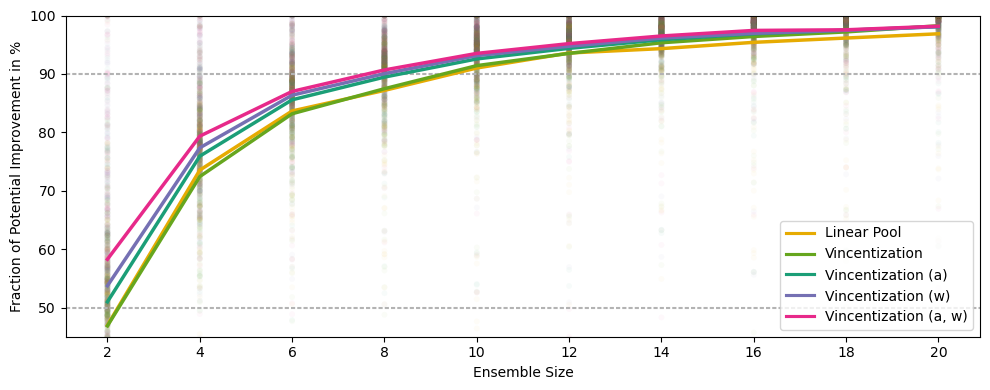

In [28]:
# Initiate Subplot
g, ax = plt.subplots(figsize=(10, 4))

# Scatterplot
sns.scatterplot(
    x='n_ens', y='crpss', 
    hue='agg', 
    data=df_plot2, 
    palette=agg_col,
    ax=ax,
    size=0.1,
    linewidth=0,
    alpha=0.03,
    )

# Add lines to scatterplot
sns.lineplot(
    x='n_ens', y='crpss', 
    hue='agg', 
    data=df_mean, 
    palette=agg_col,
    ax=ax,
    lw=2.5,
)

# Axis labels
ax.set_xlabel('Ensemble Size')
ax.set_ylabel('Fraction of Potential Improvement in %')

# y-limits
ax.set(ylim=(45,100))

# x-ticks labeling
plt.xticks(n_ens_vec)

# Horizontal benchmark lines
ax.axhline(y=50, color=".7", dashes=(2, 1), zorder=1)
ax.axhline(y=90, color=".7", dashes=(2, 1), zorder=1)

# Legend
ax.legend(
    handles, agg_names.values(),
    loc="lower right",
)

# Optimize layout
plt.tight_layout()
plt.show()

# Save fig
fig = g.figure
filename = os.path.join(plot_path, f"n_ens_ratio_improvement.pdf")
fig.savefig(filename)
log_message = f"Panel saved to {filename}"
logging.info(log_message)
plt.close(fig)